In [3]:
import os
import pandas as pd
import numpy as np
import joblib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mplfooty.pitch import Pitch

from expected_disposal_model.visualisation.afl_colours import team_colours
from expected_disposal_model.visualisation.style_config import font_path, mplstyle_path
# from visualization.visualize import get_chain, get_venue_dimensions, plot_chain_vaep, add_chain_table_vaep

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
for x in os.listdir(font_path):
    if x != ".DS_Store":
        for y in os.listdir(f"{font_path}/{x}"):
            if y.split(".")[-1] == "ttf":
                fm.fontManager.addfont(f"{font_path}/{x}/{y}")
                try:
                    fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
                except Exception:
                    continue

In [5]:
plt.style.use(mplstyle_path + "/dark_theme.mplstyle")

Load Data

In [7]:
chain_data = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-disposal-model/data/predictions/predictions_disposal_v1.csv")
chain_data.tail()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,type_Kick_a0,type_Handball_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,outcome_effective_a2,outcome_ineffective_a2,outcome_clanger_a2,quarter_a2,quarter_seconds_a2,overall_seconds_a2,start_x_a2,start_y_a2,end_x_a2,end_y_a2,dx_a2,dy_a2,movement_a2,team_1,team_2,time_delta1,time_delta2,dx_a01,dy_a01,move_a01,dx_a02,dy_a02,move_a02,Disposal,DisposalTrainingSet,DisposalTestSet,DisposalValidationSet,xgb_preds,xgb_probas,xgb_probas_cal
427203,2023F4_Collingwood_BrisbaneLions,240,1845.0,4,1771.0,7759.0,Collingwood,Scott Pendlebury,-45.0,-38.0,-27.0,-35.0,Kick,effective,True,False,4,1771.0,7759.0,-45.0,-38.0,-27.0,-35.0,18.0,3.0,18.248288,False,False,True,False,False,4,1769.0,7757.0,-46.0,-38.0,-45.0,-38.0,1.0,0.0,1.000000,True,False,True,False,False,4,1768.0,7756.0,-23.0,-35.0,-46.0,-38.0,-23.0,-3.0,23.194827,True,True,-2.0,-3.0,0.0,0.0,0.0,-1.0,0.0,1.000000,1,False,True,False,1,0.985303,0.979758
427204,2023F4_Collingwood_BrisbaneLions,240,1847.0,4,1779.0,7767.0,Collingwood,Tom Mitchell,-29.0,-34.0,-46.0,-48.0,Kick,effective,True,False,4,1779.0,7767.0,-29.0,-34.0,-46.0,-48.0,-17.0,-14.0,22.022716,False,False,True,False,False,4,1773.0,7761.0,-27.0,-35.0,-29.0,-34.0,-2.0,1.0,2.236068,True,False,True,False,False,4,1771.0,7759.0,-45.0,-38.0,-27.0,-35.0,18.0,3.0,18.248288,True,True,-6.0,-8.0,0.0,0.0,0.0,2.0,-1.0,2.236068,1,True,False,False,1,0.990963,0.986798
427205,2023F4_Collingwood_BrisbaneLions,240,1849.0,4,1788.0,7776.0,Collingwood,Brody Mihocek,-49.0,-48.0,16.0,-63.0,Kick,effective,True,False,4,1788.0,7776.0,-49.0,-48.0,16.0,-63.0,65.0,-15.0,66.708320,False,False,True,False,False,4,1780.0,7768.0,-46.0,-48.0,-49.0,-48.0,-3.0,0.0,3.000000,True,False,True,False,False,4,1779.0,7767.0,-29.0,-34.0,-46.0,-48.0,-17.0,-14.0,22.022716,True,True,-8.0,-9.0,0.0,0.0,0.0,3.0,0.0,3.000000,1,True,False,False,0,0.330212,0.353317
427206,2023F4_Collingwood_BrisbaneLions,240,1852.0,4,1794.0,7782.0,Collingwood,Will Hoskin-Elliott,14.0,-52.0,26.0,-47.0,Kick,ineffective,True,False,4,1794.0,7782.0,14.0,-52.0,26.0,-47.0,12.0,5.0,13.000000,False,False,True,False,False,4,1793.0,7781.0,14.0,-53.0,14.0,-52.0,0.0,1.0,1.000000,False,False,True,False,False,4,1792.0,7780.0,16.0,-63.0,14.0,-53.0,-2.0,10.0,10.198039,True,True,-1.0,-2.0,0.0,0.0,0.0,0.0,-1.0,1.000000,0,False,True,False,1,0.904349,0.894810
427207,2023F4_Collingwood_BrisbaneLions,240,1853.0,4,1805.0,7793.0,Collingwood,Will Hoskin-Elliott,26.0,-47.0,26.0,-47.0,Kick,effective,True,False,4,1805.0,7793.0,26.0,-47.0,26.0,-47.0,0.0,0.0,0.000000,True,False,False,True,False,4,1794.0,7782.0,14.0,-52.0,26.0,-47.0,12.0,5.0,13.000000,False,False,True,False,False,4,1793.0,7781.0,14.0,-53.0,14.0,-52.0,0.0,1.0,1.000000,True,True,-11.0,-12.0,0.0,0.0,0.0,-12.0,-5.0,13.000000,1,True,False,False,1,0.590744,0.604503


Plotting Effective Disposals

In [57]:
match_id = "2023F4_Collingwood_BrisbaneLions"
match_data = chain_data[chain_data['match_id'] == match_id]
disposals = match_data[(match_data['action_type'] == 'Handball') | (match_data['action_type'] == 'Kick')]
disposals = disposals[disposals['outcome_type'] == 'effective']
kicks = disposals[(disposals['action_type'] == 'Kick')]
handballs = disposals[(disposals['action_type'] == 'Handball')]
collingwood_kicks, collingwood_handballs = kicks[kicks['team'] == 'Collingwood'], handballs[handballs['team'] == 'Collingwood']
brisbane_kicks, brisbane_handballs = kicks[kicks['team'] == 'Brisbane Lions'], handballs[handballs['team'] == 'Brisbane Lions']

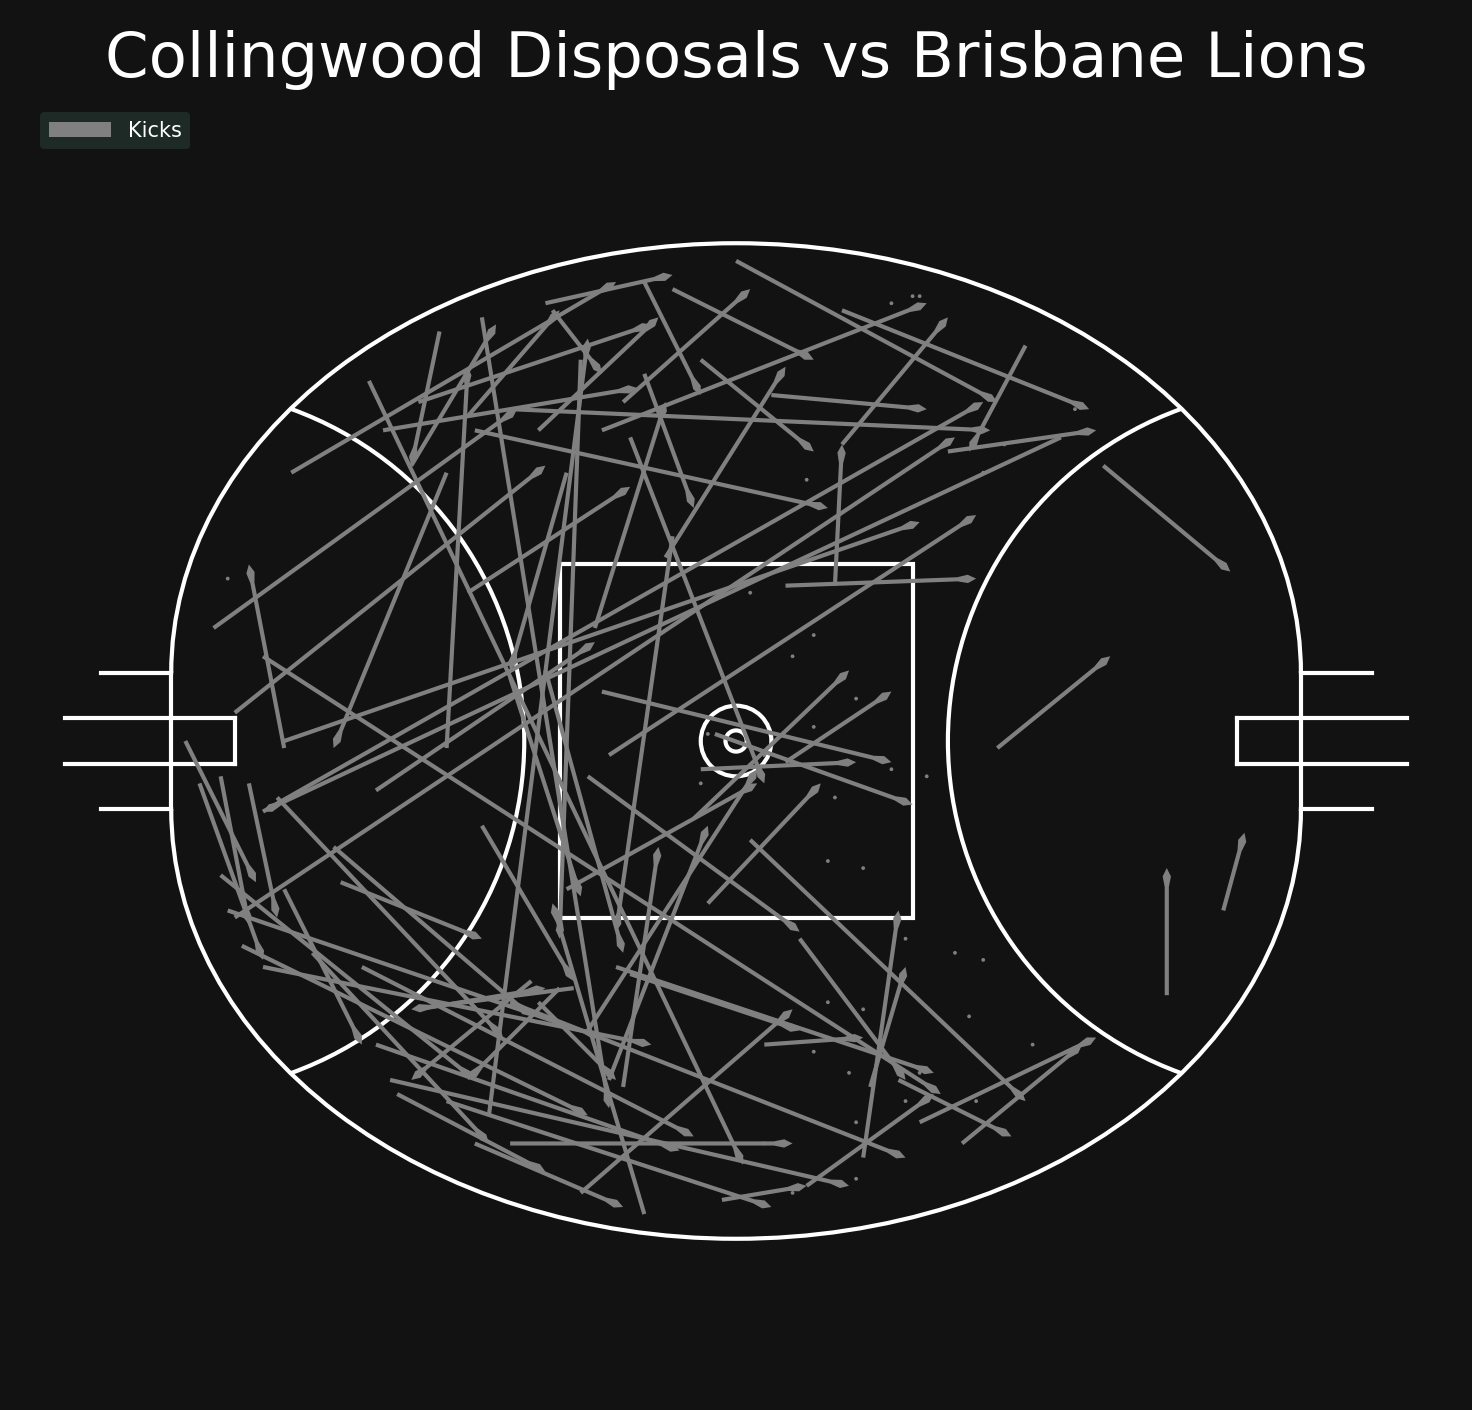

In [61]:
pitch = Pitch(pitch_width=141, pitch_length=160, line_zorder=1, line_colour='w', line_width=1)
fig, ax = pitch.draw()
fig.dpi = 300
kick_start_x, kick_end_x = collingwood_kicks['start_x'], collingwood_kicks['end_x']
kick_start_y, kick_end_y = collingwood_kicks['start_y'], collingwood_kicks['end_y']
pitch.arrows(kick_start_x, kick_start_y,
             kick_end_x, kick_end_y, width=1,
             headwidth=2, headlength=2, color='grey', ax=ax, label='Kicks')
# Set up the legend
ax.legend(facecolor='#22312b', handlelength=3, edgecolor='None', fontsize=5, loc='upper left')

# Set the title
ax_title = ax.set_title('Collingwood Disposals vs Brisbane Lions', fontsize=15)

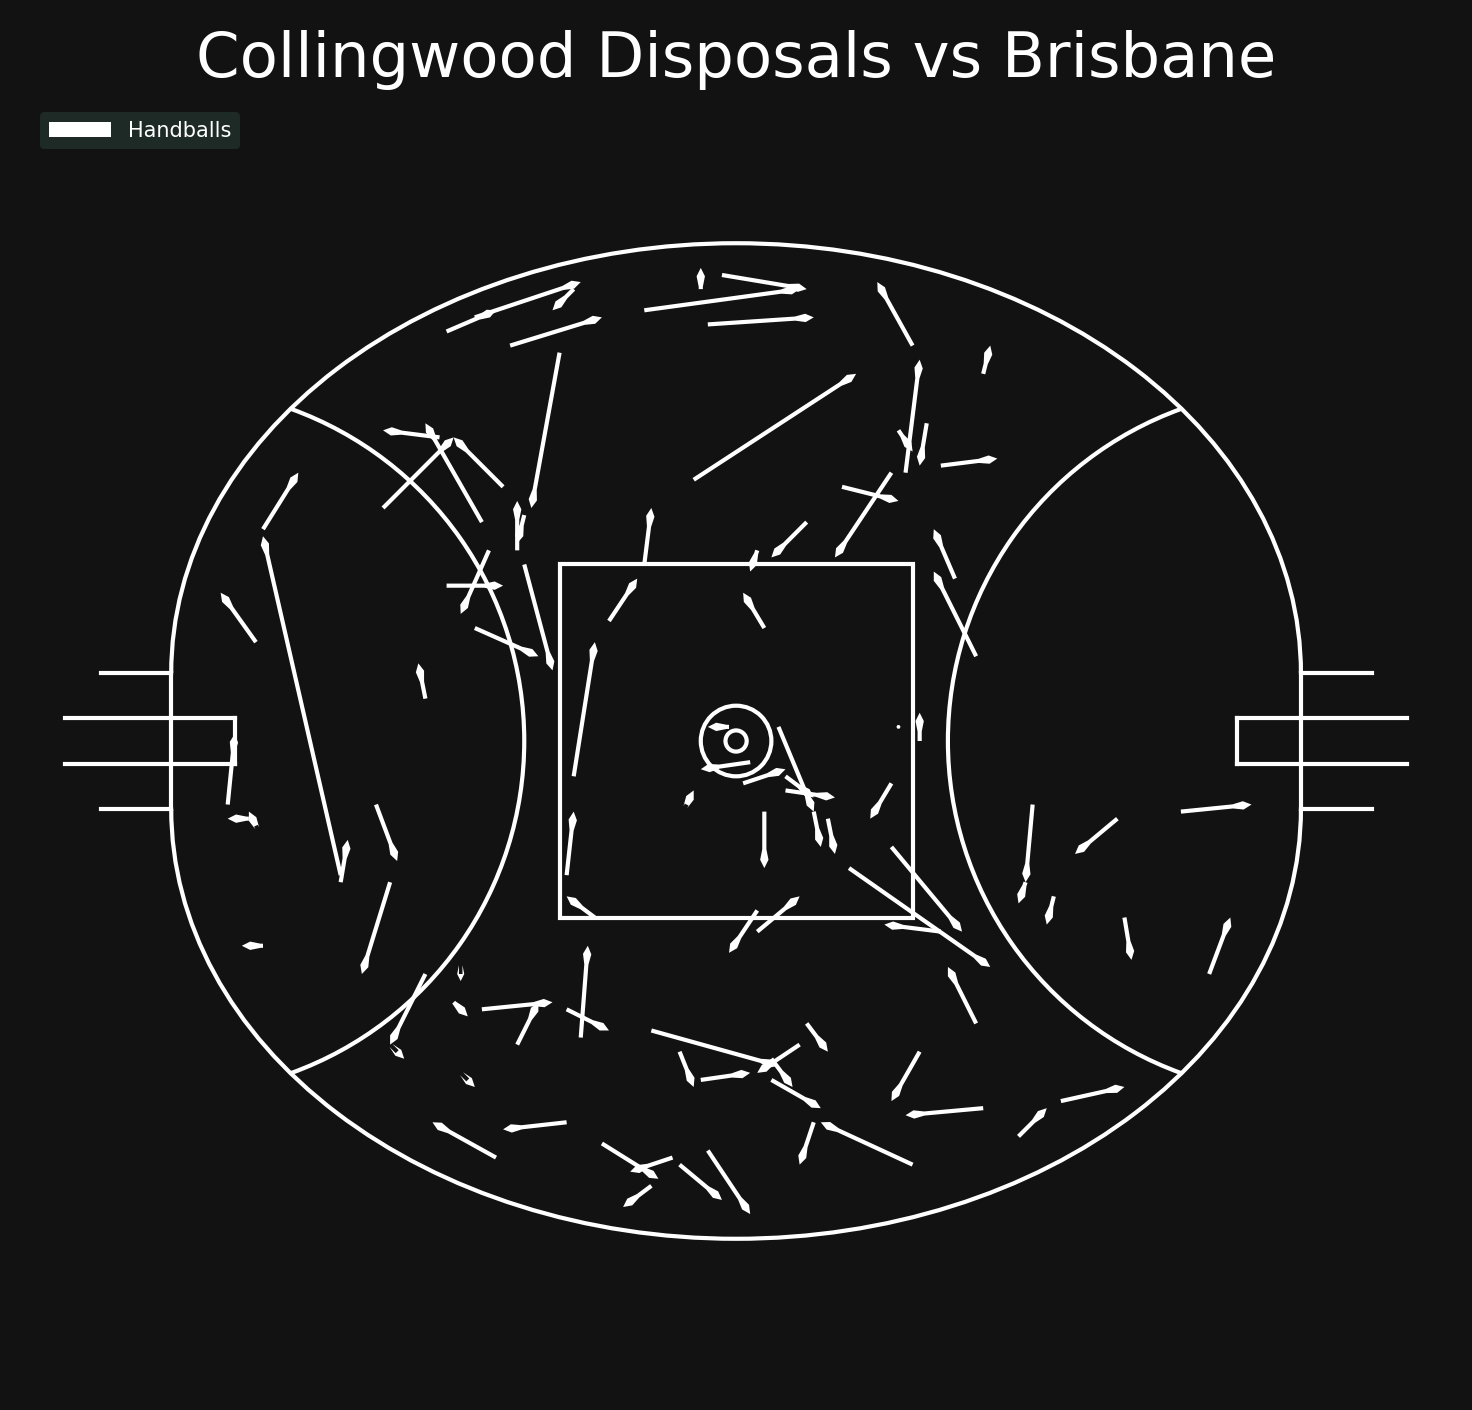

In [62]:
pitch = Pitch(pitch_width=141, pitch_length=160, line_zorder=1, line_colour='w', line_width=1)
fig, ax = pitch.draw()
fig.dpi = 300

handball_start_x, handball_end_x = collingwood_handballs['start_x'], collingwood_handballs['end_x']
handball_start_y, handball_end_y = collingwood_handballs['start_y'], collingwood_handballs['end_y']
pitch.arrows(handball_start_x, handball_start_y,
             handball_end_x, handball_end_y, width=1,
             headwidth=2, headlength=2, color='w', ax=ax, label='Handballs')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=3, edgecolor='None', fontsize=5, loc='upper left')

# Set the title
ax_title = ax.set_title('Collingwood Disposals vs Brisbane', fontsize=15, color = team_colours['Collingwood']['positive'])

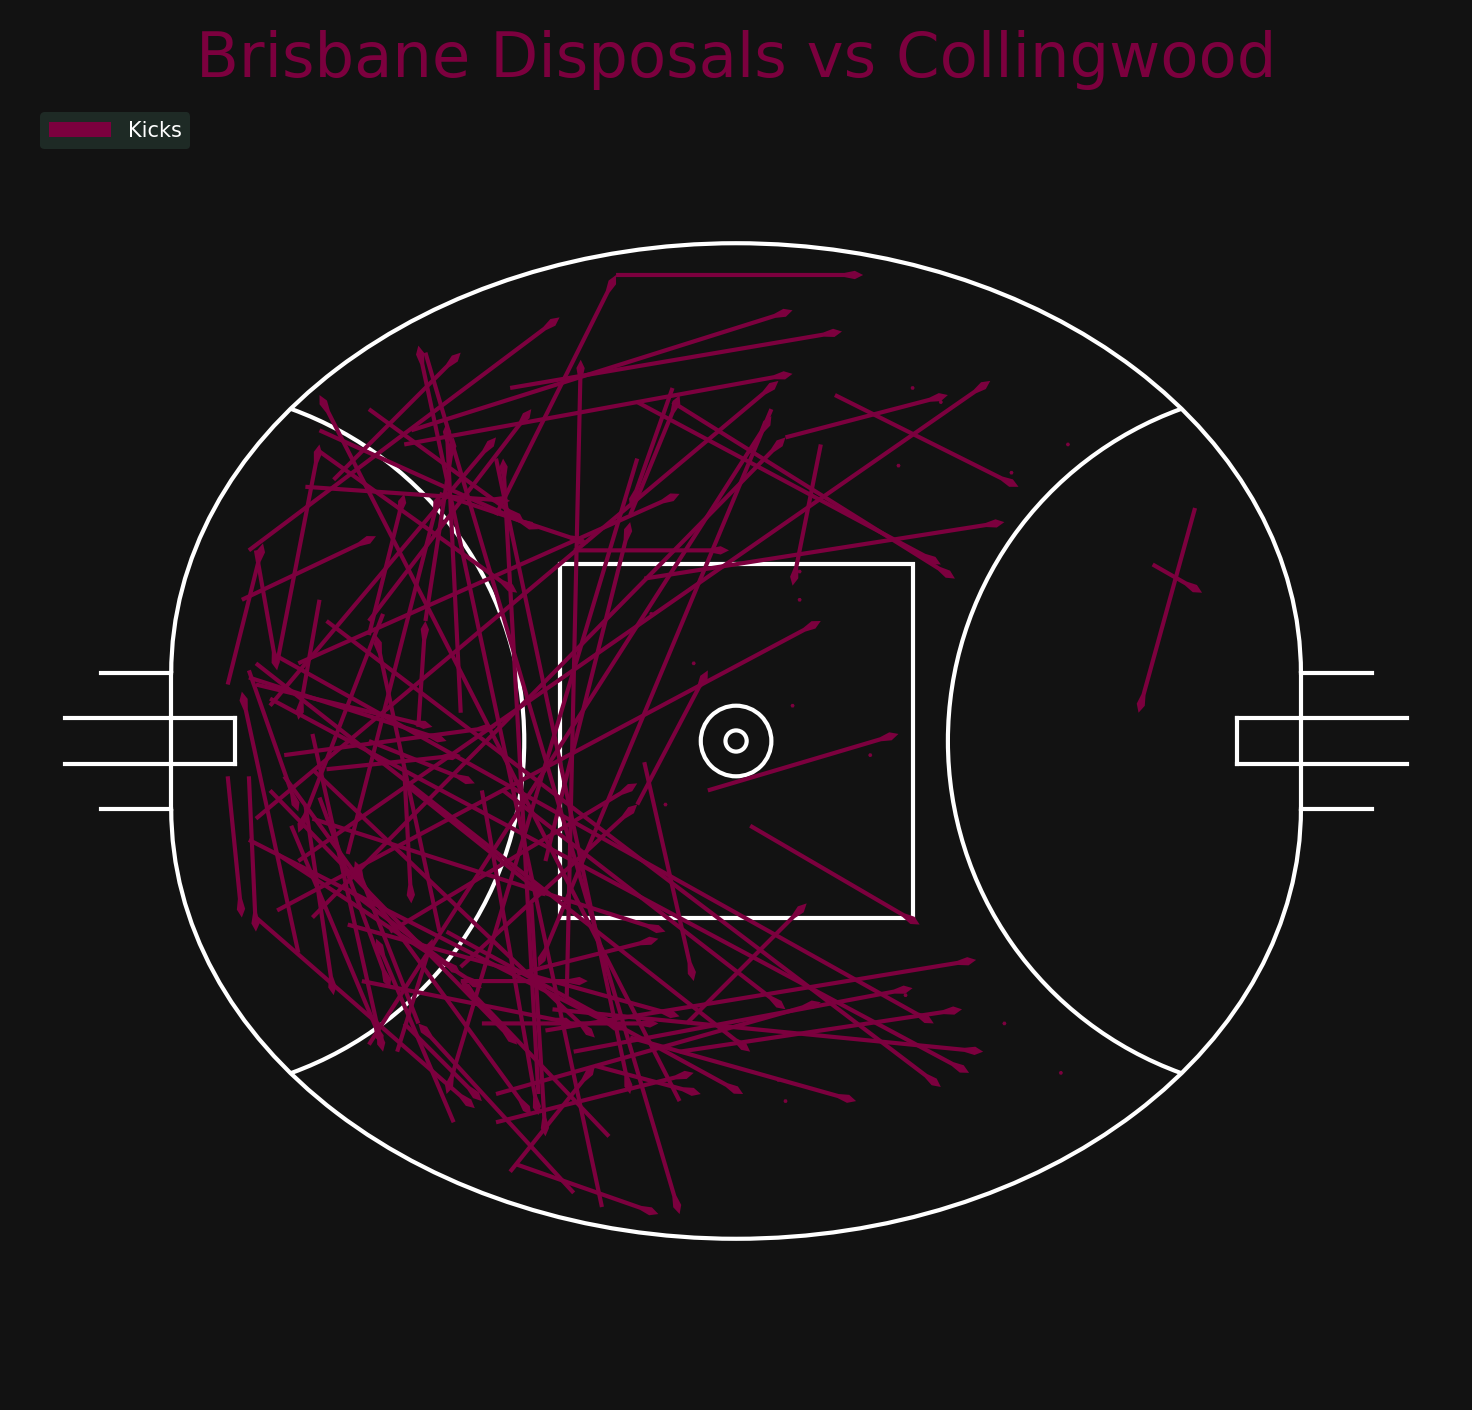

In [63]:
pitch = Pitch(pitch_width=141, pitch_length=160, line_zorder=1, line_colour='w', line_width=1)
fig, ax = pitch.draw()
fig.dpi = 300
kick_start_x, kick_end_x = brisbane_kicks['start_x'], brisbane_kicks['end_x']
kick_start_y, kick_end_y = brisbane_kicks['start_y'], brisbane_kicks['end_y']
pitch.arrows(kick_start_x, kick_start_y,
             kick_end_x, kick_end_y, width=1,
             headwidth=2, headlength=2, color=team_colours['Brisbane Lions']['positive'], ax=ax, label='Kicks')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=3, edgecolor='None', fontsize=5, loc='upper left')

# Set the title
ax_title = ax.set_title('Brisbane Disposals vs Collingwood', fontsize=15, color = team_colours['Brisbane Lions']['positive'])

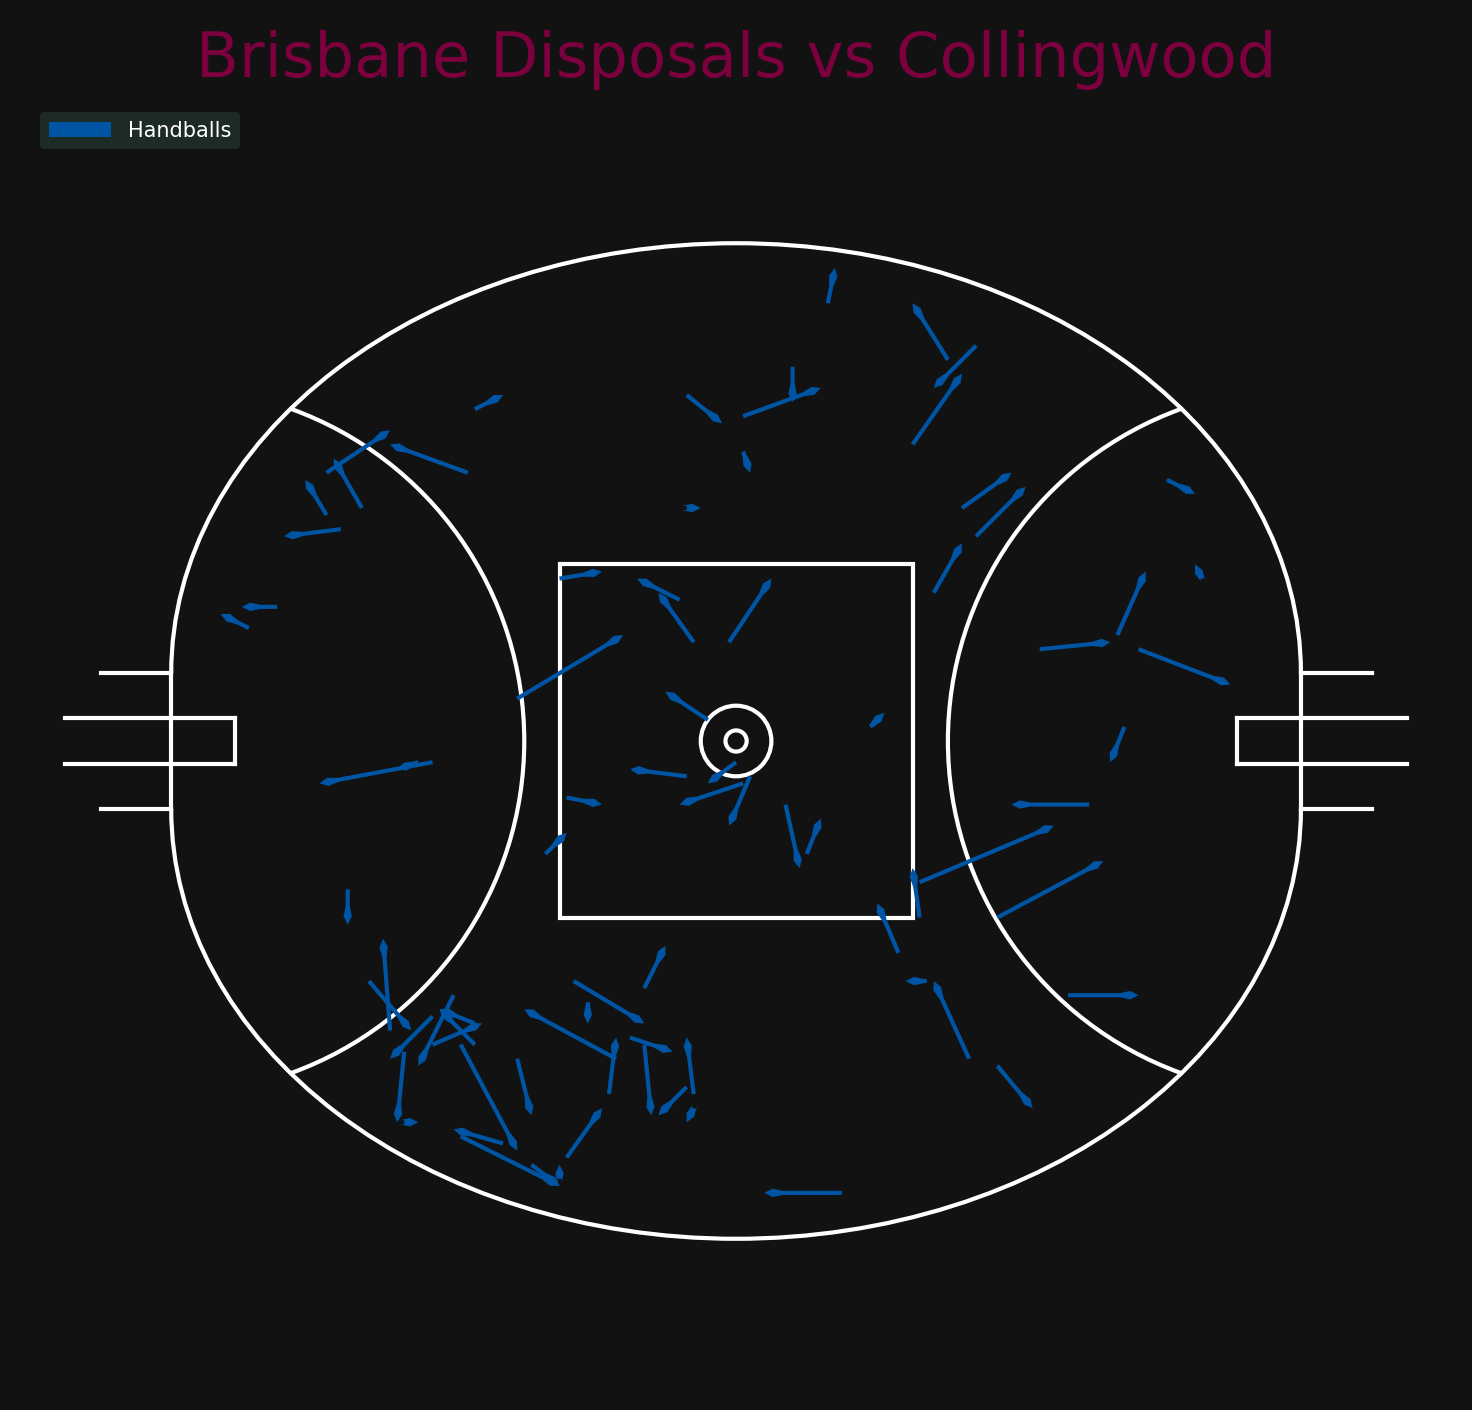

In [64]:
pitch = Pitch(pitch_width=141, pitch_length=160, line_zorder=1, line_colour='w', line_width=1)
fig, ax = pitch.draw()
fig.dpi = 300

handball_start_x, handball_end_x = brisbane_handballs['start_x'], brisbane_handballs['end_x']
handball_start_y, handball_end_y = brisbane_handballs['start_y'], brisbane_handballs['end_y']
pitch.arrows(handball_start_x, handball_start_y,
             handball_end_x, handball_end_y, width=1,
             headwidth=2, headlength=2, color=team_colours['Brisbane Lions']['negative'], ax=ax, label='Handballs')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=3, edgecolor='None', fontsize=5, loc='upper left')

# Set the title
ax_title = ax.set_title('Brisbane Disposals vs Collingwood', fontsize=15, color = team_colours['Brisbane Lions']['positive'])

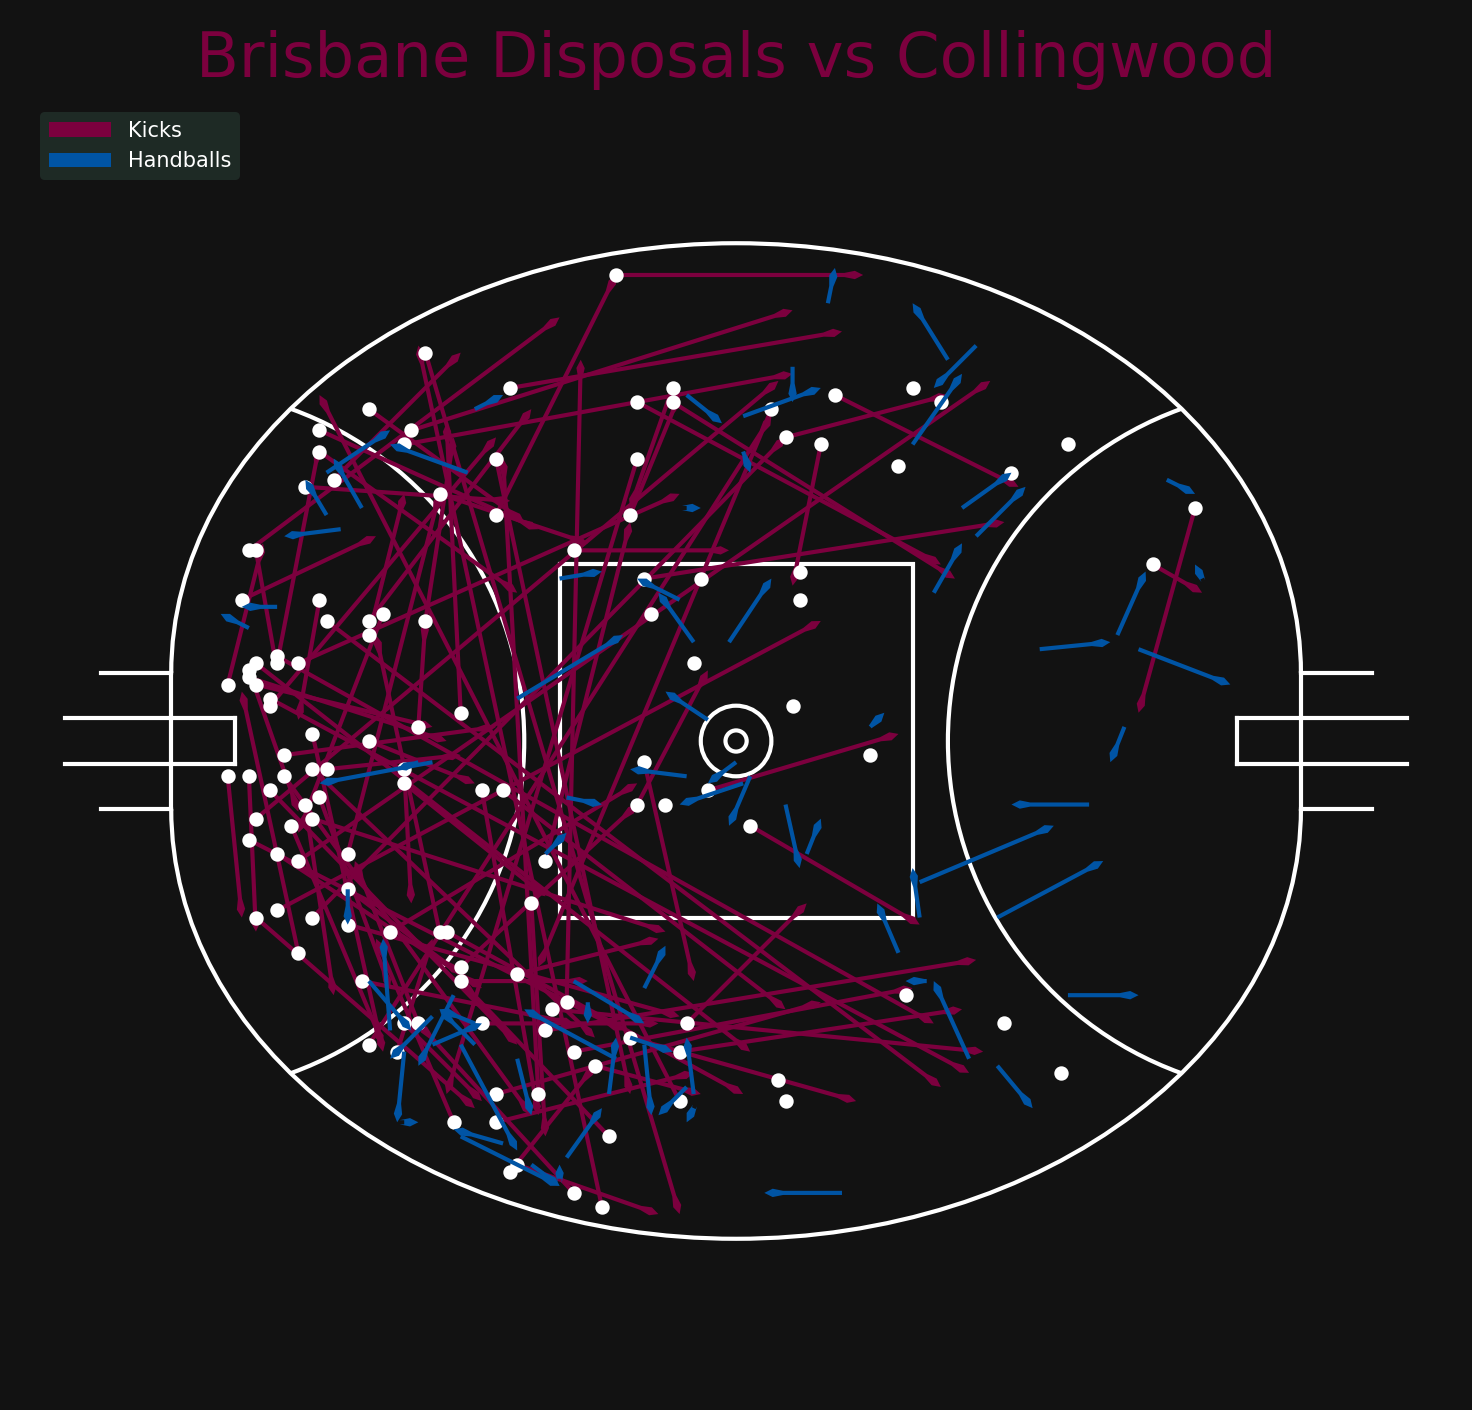

In [74]:
pitch = Pitch(pitch_width=141, pitch_length=160, line_zorder=1, line_colour='w', line_width=1)
fig, ax = pitch.draw()
fig.dpi = 300
kick_start_x, kick_end_x = brisbane_kicks['start_x'], brisbane_kicks['end_x']
kick_start_y, kick_end_y = brisbane_kicks['start_y'], brisbane_kicks['end_y']
pitch.arrows(kick_start_x, kick_start_y,
             kick_end_x, kick_end_y, width=1,
             headwidth=2, headlength=2, color=team_colours['Brisbane Lions']['positive'], ax=ax, label='Kicks')
pitch.scatter(kick_start_x, kick_start_y, ax=ax, marker = "o", color = 'w', s=6)

handball_start_x, handball_end_x = brisbane_handballs['start_x'], brisbane_handballs['end_x']
handball_start_y, handball_end_y = brisbane_handballs['start_y'], brisbane_handballs['end_y']
pitch.arrows(handball_start_x, handball_start_y,
             handball_end_x, handball_end_y, width=1,
             headwidth=2, headlength=2, color=team_colours['Brisbane Lions']['negative'], ax=ax, label='Handballs')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=3, edgecolor='None', fontsize=5, loc='upper left')

# Set the title
ax_title = ax.set_title('Brisbane Disposals vs Collingwood', fontsize=15, color = team_colours['Brisbane Lions']['positive'])